# PROJECT: Course Optimization for Data Science
## Optimization strategies for anomaly detection
## with One class Support Vector Machines (OCSVM)

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the dual for the one-class SVM model
- implement a one-class SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers with: Proximal gradient, Coordinate Descent, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 7th of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "eya"
ln1 = "kalboussi"
fn2 = "lea"
ln2 = "bresson"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_kalboussi_eya_and_bresson_lea.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install cvxopt`

or

`pip install cvxopt`

if you have `conda` or `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: One-class SVM

The original formulation of the One-Class SVM introduced by Schölkopf [1] is given by

$$
    (\mathcal{P}): \left\{
	\begin{aligned}
	\min_{w, \rho, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq \rho - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
    \right.
$$

where $\nu \in (0, 1]$ is a user-specified parameter controlling the proportion of outliers and the proportion of support vectors.

Getting rid of the slack variables $\xi_i, 1 \leq i \leq n$ one can also obtain the following equivalent optimization problem

$$
	\min_{w, \rho} \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \max(0, \rho - \langle w, x_i \rangle) \, .
$$

The idea is that the lower is $\langle w, x_i \rangle$ is the more $x_i$ is an anomaly and if $\langle w, x_i \rangle \geq \rho$ then the model predicts the sample is normal. $\langle w, x_i \rangle$ corresponds to the decision function and $\textrm{sign}(\langle w, x_i \rangle - \rho)$ as the prediction (1 means normal sample).

[1] Schölkopf et al. Estimating the support of a high-dimensional distribution. Neural Computation. 2001

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>


First, the function $f:(w, \rho, \xi) \rightarrow \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i $ is convex since it is a quadratic function.



Let $ C = \{w, \rho, \xi \: | \:  \langle w, x_i \rangle  - \rho +  \xi_i   \geq 0,   \xi_i \geq 0 \text{ for } 1 \leq i \leq n  \}$. 

- $\langle w, x_i \rangle  - \rho +  \xi_i   \geq 0$ is an affine function thus it is convex.
- $\xi_i \geq 0 $ is also an affine function thus it is convex.


To conclude, since both $f$ and the inequality constraints are convex, the problem ($\mathcal{P}$) is convex.

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>
      By looking at the saddle points of the Lagrangian $\mathcal{L}(w, \rho, \mu)$ of $\mathcal{P}$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.
    </li>
    </ul>
</div>

We will **assume here qualification of the contraints** and that **strong duality holds**.

**Remark:** The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

The Lagrangien of the Primal problem is the function $ \mathcal{L} : \mathcal{R}^n \times \mathcal{R}_+^n \rightarrow \mathcal{R} $: 
$$ \mathcal{L}(w,\rho,\mu, \lambda) = \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i - \sum_{i=1}^n \mu_i ( \langle w, x_i \rangle - \rho + \xi_i ) - \sum_{i=1}^n \lambda_i \xi_i $$
with Lagrange multipliers $ \mu_i \geq 0 $ and $\lambda_i \geq 0 $.


It can be rewritten as: 
$$ \mathcal{L}(w,\rho,\mu, \lambda) = \frac{1}{2} w^T w - \rho +  \frac{1}{\nu n}  \xi - \mu^T ( G w - \rho + \xi ) - \lambda^T \xi $$


$$ \Leftrightarrow \mathcal{L}(w,\rho,\mu, \lambda) = \frac{1}{2} w^T w - \rho + ( \frac{1}{\nu n}  - \lambda^T) \xi - \mu^T ( G w - \rho + \xi ) $$

with
$
 G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}.
$

The Karush Kuhn et Tucker conditions are:
- $ G w - \rho + \xi \le 0 $ (primal constraint),

- $ \mu \in \mathcal{R}_+^n $    (dual constraint),

- $ \mu^T ( G w - \rho + \xi ) = 0 $  (complementarity),

- $ \nabla \mathcal{L} = 0$ (stationarity)  .


The stationarity condition implies :



$\frac{\partial \mathcal{L}(w,\rho,\mu, \lambda)} { \partial w } = w - G^T \mu =0 \Rightarrow w = G^T \mu $
 
$\frac{\partial \mathcal{L}(w,\rho,\mu, \lambda)} { \partial \rho } = -1 + \mu^T \mathbb{1}_n = 0 \Rightarrow \mu^T \mathbb{1}_n = 1.$
 
$\frac{\partial \mathcal{L}(w,\rho,\mu, \lambda)} {\partial \xi} = (\frac{1}{\nu n} \mathbb{1}_n^T - \lambda^T) \mathbb{1}_n - \mu^T \mathbb{1}_n = 0 \Rightarrow \frac{1}{\nu n} \mathbb{1}_n^T - \lambda^T - \mu^T = 0 $

 
The dual problem $\mathcal{D}$ associated to the primal problem $\mathcal{P}$ is: $$ \max_{\mu \in R_+^n} \inf_{w} \quad  \mathcal{L}(w,\rho,\mu) $$

Using the stationnary condition on $w$:
$$\Leftrightarrow \max_{\mu \in R_+^n}\quad   \frac{-1}{2} \mu ^T GG^T\mu - ( 1 -  \mu^T\mathbb{1}_n)\rho +  (\frac{1}{\nu n}  - \lambda^T - \mu^T) \xi $$



$\Leftrightarrow$
$
    \left\{
	\begin{aligned}
	\max_{\mu \in R_+^n} & \quad \frac{-1}{2} \mu^TGG^T\mu \\
	\text{s.t.} & \quad \mu^T \mathbb{1}_n = 1 \\
    & \quad \frac{1}{\nu n} \mathbb{1}_n^T - \lambda^T - \mu^T = 0 
	\end{aligned}
    \right.
$
$\Leftrightarrow $
 $   \left\{
	\begin{aligned}
	\min_{\mu \in R_+^n} & \quad \frac{1}{2} \mu^TGG^T\mu  \\
	\text{s.t.} & \quad \mu^T \mathbb{1}_n = 1\\
    & \quad \frac{1}{\nu n} \mathbb{1}_n^T - \lambda^T - \mu^T = 0 
	\end{aligned}
    \right.
$

However, given $\lambda, \mu \in \mathcal{R}_+^n $, the third stationnary condition can be replaced by the following constraint:
$$
\frac{1}{\nu n} \mathbb{1}_n^T - \mu^T = \lambda^T \geq 0 \rightarrow 0 \leq \mu \leq \frac{1}{\nu n}
$$

Finally, we have:
$$
    (\mathcal{D}): 
    \left\{
	\begin{aligned}
	\min_{\mu \in R_+^n} & \quad \frac{1}{2} \mu^TGG^T\mu \\
	\text{s.t.} & \quad \mu^T \mathbb{1}_n = 1 \\
    & \quad 0 \leq \mu \leq \frac{1}{\nu n}  
	\end{aligned}
    \right.
$$

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
     <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ (-1 if anomaly else 1) is given by:
        $$
        y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace .
        $$
        The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i x_i$
    </li>
    </ul>
</div>

The prediction function is $ y = \textrm{sign}(\langle w, x_i \rangle - \rho)$.

We know (from Question 2) that at the optimum $w^* = G^T \mu  = \sum_{i = 1}^n \mu_i x_i$.

Hence, the prediction function for a new sample x is: $$y =  \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) .$$

## Part 1: Implementation of solver using cvxopt

Let's make a toy dataset in dimension 2. When using a linear kernel we need all samples to have positive values and the outliers to be close to the origin.

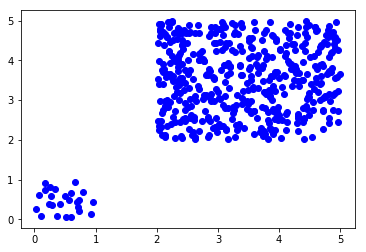

In [3]:
def make_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = rng.uniform(low=2, high=5, size=(int(n_samples * (1 - contamination)), 2))
    X_outliers = rng.uniform(low=0, high=1, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_dataset(500)
plt.scatter(X[:, 0], X[:, 1], color='b');

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} P x + q^\top x
  \\
   & \textrm{s.t.}\; A x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

See documentation: http://cvxopt.org/userguide/coneprog.html#quadratic-programming

In [4]:
import cvxopt


def qp(P, q, A , b  , C, verbose=True, Condition = True):
    # Gram matrix
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                     np.diag(np.ones(n))], axis=0))
    if Condition :
        A = cvxopt.matrix(A)
        b = cvxopt.matrix(b)
    
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))
        

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    if Condition:
        solution = cvxopt.solvers.qp(P, q, G, h, A, b, solver='mosec')
    else: 
        solution = cvxopt.solvers.qp(P, q, G, h, solver='mosec')
    
 
    return np.ravel(solution['x'])

Definition of the linear kernel:

In [5]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

**Remark:** You can use `sklearn.metrics.pairwise_distances` to avoid the for loops and make it faster.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Modify the following cell to solve the One-Class SVM dual problem.</li>
    </ul>
</div>

In [6]:
def ocsvm_solver(K, nu=0.1):

    n = K.shape[0]
    P = K
    q = np.zeros(n)
    A = np.ones((1, n))
    b = np.ones(1)
    C = 1 / (nu * n)
    mu = qp(P, q, A, b, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your ocsvm_solver is completed:
mu_support, idx_support = ocsvm_solver(K)
print("Number of support vectors: %s" % idx_support.size)

Number of support vectors: 50


<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Compute w using mu.</li>
    </ul>
</div>

We know from Question 2 that at the optimum $w = G^T \mu  = \sum_{i = 1}^n \mu_i x_i$.

In [7]:
X_support = X[idx_support]
w = X_support.T.dot(mu_support)
w

array([ 1.37631398,  1.37252753])

<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
      <li>Using complementary slackness, explain how to obtain $\rho$ from $\mu$.</li>
    </ul>
</div>

**HINT:** Use the fact that for all support vectors for which $0 < \mu_i < \frac{1}{\nu n}$ one has $w^{t}x_{i} = \rho$.

Let us consider both the Primal and Dual problem studied above:

$$
    (\mathcal{P}): \left\{
	\begin{aligned}
	\min_{w, \rho, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq \rho - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
    \right.
$$

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

Let x be the solution of problem $(\mathcal{P})$ and $\mu$ the solution of problem $(\mathcal{D})$.

Complementary slackness allows us to consider the variable $x_j$  in the primal problem equal to 0 if the $j^{th}$ constraint in $(\mathcal{D})$ is not binding. 
Therefore, if there exists $i$ such that $0<\mu_i<\frac{1}{\nu n}$ then the second constraint of the dual problem is not binding and $\xi_i = 0$. In addition, if $\mu_i$ is greater than 0, then the $i^{th}$ constraint in $(\mathcal{P})$ is binding, i.e. $\langle w, x_i \rangle = \rho - \xi_i$.

Consequently,
$$
\xi _i = 0
\rightarrow \rho = \langle w, x_i \rangle = x_i^T \mu x
$$


To compute $\rho$, we have to find $\mu_i $ such that $\mu_i < \frac{1}{\nu n}$.



In [8]:
def compute_rho(K, mu_support, idx_support):

    K_support = K[idx_support][:, idx_support]
    idx_constraint = np.argmin(mu_support) 
    rho = mu_support.dot(K_support)[idx_constraint]
    
    return rho


Compute_rho = compute_rho(K, mu_support, idx_support)

<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
      <li>Verify that you find the same values as what scikit-learn gives. You should have the same support vectors and:


`rho = -ocsvm.intercept_[0] / (ocsvm.nu * len(K))`

and `mu_support = ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K))`</li>
    </ul>
</div>

In [9]:
from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from sklearn.svm import OneClassSVM

X = make_dataset(150)

ocsvm = OneClassSVM(kernel='linear', nu=0.05)
ocsvm.fit(X)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu = ocsvm.nu)
rho = compute_rho(K, mu_support, idx_support)

print('nu = ',1/(0.05*K.shape[0]))

# Check indices of support vectors
print(ocsvm.support_)
print(idx_support)

# Check rho
print('Check rho',rho)
print('Check rho',-ocsvm.intercept_[0] / (ocsvm.nu * len(K)))

# Check dual variables
print(mu_support)
print(ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

# Run formal tests:
assert_array_almost_equal(ocsvm.support_, idx_support)
assert_almost_equal(rho, -ocsvm.intercept_[0] / (ocsvm.nu * len(K)))
assert_array_almost_equal(mu_support, ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

nu =  0.1342281879194631
[  4  23  66  72  90  92 109 113]
[  4  23  66  72  90  92 109 113]
Check rho 2.16400352023
Check rho 2.16400355501
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]


Check your code by running the following cell:

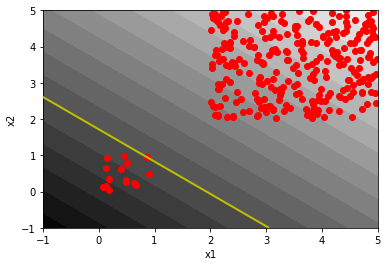

In [10]:
X = make_dataset(300)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.05)
rho = compute_rho(K, mu_support, idx_support)

def plot_ocsvm(X, mu_support, idx_support, rho, kernel=kernel):
    # Compute decision function on a grid
    X1, X2 = np.mgrid[-1:5.1:0.2, -1:5.1:0.2]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Compute dot products
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Compute decision function
    decision = G.dot(mu_support) - rho

    # Compute predict label
    y_pred = np.sign(decision)

    # Plot decision boundary
    plt.plot(X[:,0], X[:, 1], 'or', linewidth=2)
    Z = np.reshape(decision, (na, nb))
    plt.contourf(X1, X2, Z, 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, Z, [0], colors='y', linewidths=2, zorder=10)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-1, 5])
    plt.ylim([-1, 5])

plot_ocsvm(X, mu_support, idx_support, rho)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
      <li>Without any implementation, can you justify if you can apply any of the algorithm, among proximal gradient, coordinate descent, stochastic gradient descent and L-BFGS to the dual problem?
      </li>
    </ul>
</div>

The problem $(\mathcal{D})$ is a constrained quadratic problem and can be rewritten:
$$ \min_{\mu} F(\mu) + g(\mu) $$
where: 
- $F(\mu) = \frac{1}{2}\mu^{\top}GG^{t}\mu $

- $g(\mu) = I_c(\mu) $ with $ C= \left \{ \mu \text{  }| \text{ } \mu^{\top}1_n = 1 \text{ and } 0 \leq \mu \leq \frac{1}{\nu n} \right \} $




- Proximal gradient:

The function $g$ is not prox-friendly, hence we cannot use the proximal gradient method.


- Coordinate descent: 

We cannot apply the cordinate descent since the function $g$ is non-separable.

- Stochastic gradient descent:  

The stochastic gradient descent does not work since $g$ is not separable nor prox-friendly. 


- L-BFGS : 

This algorithm is used for smooth unconstrained problems but can be extended to handle simple box constraints. Consequently, L-BFGS can not handle the constraint "$\sum_i \mu_i = 1 $". We can not apply it.





***

To conclude, the objective function $F$ is convex, differentiable and smooth but we cannot apply any of the proposed algorithm to solve $(\mathcal{D})$ because there is a problem with the "$\sum_i \mu_i = 1$" constraint ($\rho \neq$ 0 in the primal).

## Part 1: non-linear case with kernels

Another scenario is when the boundary between normal samples and outliers is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
      <li>Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$
      </li>
    </ul>
</div>

The dual problem can be reformulated as follow: 

$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu_i} &\frac{1}{2} \sum_{i,j} \mu_i  \mu_j K(x_i,x_j)
 \\
 \mathrm{s.t.}& \sum_i \mu_i = 1
 \\
 \mathrm{and}& 0 \leq \mu_i \leq \frac{1}{\nu n}
 \end{array}
 \right .
$

$$
\Leftrightarrow
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}K\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

It is the "kernel trick": the outcome of the decision function only relies on the dot product of the vectors in the feature space, it is not necessary to perform an explicit projection to this space.


The decision function is : $ y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i K(x_i, x) - \rho) \enspace $.


We will use another dataset to evaluate this:

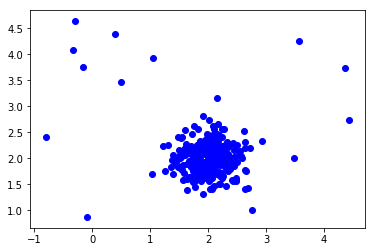

In [11]:
def make_blob_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = 0.3 * rng.normal(size=(int(n_samples * (1. - contamination)), 2)) + 2
    X_outliers = rng.uniform(low=-1, high=5, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_blob_dataset(300)
plt.scatter(X[:, 0], X[:, 1], color='b');

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Update your kernel function so it computes the Gaussian kernel:
      
        $$
            K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
        $$

        where $\gamma > 0$ is the kernel bandwidth.
      </li>
    </ul>
</div>

In [12]:
from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = .3
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma * (np.linalg.norm(X1[i]-X2[j])**2))
    return K

Using the change above the follwing code should allow you to nicely separate the dense region from the outliers

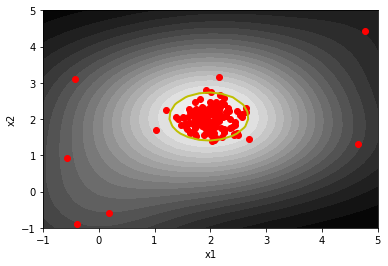

In [13]:
X = make_blob_dataset(150)

K = rbf_kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.1)
rho = compute_rho(K, mu_support, idx_support)

plot_ocsvm(X, mu_support, idx_support, rho, kernel=rbf_kernel)

## Part 2: One-class SVM without $\rho$

Formulation for example used in:

```
Consistency of one-class SVM and related algorithms
Régis Vert and Jean-philippe Vert
NIPS 2006
```

The problem of the formuation of SVMs with the variable $\rho$ is that
it leads to an annoying constraint in the dual, namely the $\mu^{\top}1_n = 1$.

We will now see what we can do about it.

Let's consider the problem

$$
	\begin{aligned}
	\min_{w, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq 1 - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
$$

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Show that a dual problem of this problem is given by:
      
        $$
        (\mathcal{D}):
            \left\{
            \begin{array}{lll}
            \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
            \\
            \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
            \end{array}
            \right .
        $$
      </li>
    </ul>
</div>

The Lagrangien of the Primal problem is the function $ \mathcal{L}: \mathcal{R}^n \times \mathcal{R}_+^n $ : 
$$ \mathcal{L}(w,\mu, \lambda) = \frac{1}{2}\Vert w \Vert^2  + \frac{C}{ n} \sum_{i=1}^n \xi_i - \sum_{i=1}^n \mu_i ( \langle w, x_i \rangle - 1 + \xi_i ) - \sum _i \lambda_i \xi_i  $$
with Lagrange multipliers $ \mu_i \geq 0 $ and $\lambda_i \geq 0 $.


It can be rewritten as : 
$$ \mathcal{L}(w, \mu) = \frac{1}{2} w^T w + (\frac{C}{ n} \mathbb{1}_n^T - \lambda^T)  \xi - \mu^T ( G w - \mathbb{1}_n + \xi ) $$
with
$
 G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}.
$
 
The Karush Kuhn et Tucker conditions are:
- $ G w - \mathbb{1}_n  + \xi \le 0 $ (primal constraint),

- $ \mu \in \mathcal{R}_+^n $ (dual constraint),

- $ \mu^T ( G w - \mathbb{1}_n + \xi ) = 0 $ (complementarity),

- $ \nabla \mathcal{L} = 0$ (stationarity)  .


The stationarity condition implies :



$\frac{\partial \mathcal{L}(w,\xi, \mu, \lambda)} { \partial w } = w - G^T \mu =0 \Rightarrow w = G^T \mu $
 
$\frac{\partial \mathcal{L}(w,\xi,\mu, \lambda)} { \partial \xi } = \frac{C}{n} \mathbb{1}_n^T - \mu^T - \lambda ^T = 0 \Rightarrow \frac{C}{n} \mathbb{1}_n - \lambda^T = \mu ^T $


The dual problem $\mathcal{D}$ associated to the primal problem $\mathcal{P}$ is: $$ \max_{\mu \in R_+^n} \inf_{w} \quad  \mathcal{L}(w,\rho,\mu) $$

Using the stationnary condition on $w$:
$$\Leftrightarrow \max_{\mu \in R_+^n}\quad   \frac{1}{2} \mu ^T GG^T\mu + ( \frac{C}{n}  \mathbb{1}_n^T - \lambda^T)\xi - 
\mu^T ( G G^T \mu - \mathbb{1}_n + \xi ) $$
$$\Leftrightarrow \max_{\mu \in R_+^n}\quad  \frac{-1}{2} \mu ^T GG^T\mu + ( \frac{C}{n}  \mathbb{1}_n^T - \lambda^T - \mu^T)\xi + 
\mu^T  \mathbb{1}_n $$



$$\Leftrightarrow
    \left\{
	\begin{aligned}
	\max_{\mu \in R_+^n} & \quad \frac{-1}{2} \mu ^T GG^T\mu+
\mu^T  \mathbb{1}_n \\
	\text{s.t.} & \quad \frac{C}{n} \mathbb{1}_n - \lambda^T = \mu ^T
	\end{aligned}
    \right.
$$


However, given $\lambda, \mu \in \mathcal{R}_+^n $, the second stationnary condition can be replaced by the following constraint:
$$
\mu^T = \frac{C}{n} \mathbb{1}_n^T - \lambda^T \leq \frac{C}{n}
$$

Finally, we have:

$$
    (\mathcal{D}): 
    \left\{
	\begin{aligned}
	\min_{\mu \in R_+^n} & \quad \frac{1}{2} \mu^TGG^T\mu - \mu^T \mathbb{1}_n  \\
    \text{s.t} & \quad 0 \leq \mu \leq \frac{C}{ n}  
	\end{aligned}
    \right.
$$



<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
      <li> Rewrite the dual in the form:
      
            $$
            (\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
            $$

            where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

            $$
            g(\mu) = \sum_{i=1}^n g_i(\mu_i)
            $$
      </li>
    </ul>
</div>



$$
(D) : min_{\mu} f(\mu) + g(\mu)
$$

Let us now show that :
- $f$ is a smooth function of $\mu$ with L-Lipschitz gradient 
- $g$ is a non-smooth function

Let us consider : $f: \mu \rightarrow f(\mu) = \frac{1}{2} \mu^T GG^T \mu - \mu^T \mathbb{1}_n$.

$ f$ is continuously differentiable.


Differenciating $f(\mu)$ once gives : $\nabla f(\mu) = G G^T \mu - \mathbb{1}_n.  	\Rightarrow \| \nabla f(x) - \nabla f(y)\| \leq \| G G^T\|_2 \| x - y\| $,  $ \forall	  x,y \in \mathbb{R^2}$

Conclusion: $f$ is smooth and $\| G G^T\|_2  $-Lipschitz gradient.



Let us consider : $g_i: \mu_i \rightarrow g_i(\mu_i) = \mathcal{I}_{\Omega}(\mu_i) $
where : 
- $\Omega = \{ \mu \in \mathbb{R}^n_+ \quad  | \quad  0 \leq \mu \leq \frac{C}{n} \}$
- $
    \mathcal{I_{\Omega}}(\mu_i) =: 
    \left\{
	\begin{aligned}
	 0 \quad \text{if}\quad \mu_i \in \Omega  \\
    \infty \quad \text{Otherwise}  
	\end{aligned}
    \right.
$


$g$ is non-smooth since the derivative of $g_i$ for all i is not defined over $\mathbb{R}^n_+ \ \Omega$. However g is separable.

Consequently:

$$
(D) : min_{\mu} f(\mu) + g(\mu)
$$


Where:
- $f: \mu \rightarrow f(\mu) = \frac{1}{2} \mu^T GG^T \mu-  \mu^T \mathbb{1}_n  $
- $g: \mu \rightarrow g(\mu) = \sum_{i=1}^n (\mathcal{I}_{\Omega}(\mu_i))$


The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    Implement:
     <ul>
      <li> your own solver based on the QP function in cvxopt (reuse `qp` function above).</li>
      <li> your own solver of proximal gradient with and without acceleration</li>
      <li> your own version of coordinate descent</li>
      <li> an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
</div>

You will test your implementations on the Gaussian blob corrupted with some uniform noise obtained with `make_blob_dataset` function.

You will make sure that all solvers converge towards the same minimum !

You will evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory on your machine.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

**Remark:** For the coordinate descent method there exist some smart updates provided you use a linear kernel.

**BONUS (Hard):** Explain without implementing it how such smart updates could work for the coordinate descent solver.

**IMPORTANT : This question 12 is the most important and will constitute half of the final grade on the project !**

## Solution 


We want to minimize $f(\mu) + g(\mu)$

Where
- $f(\mu) = \frac{1}{2} \mu^T GG^T \mu-  \mu^T \mathbb{1}_n  $
- $g(\mu) = \sum_{i=1}^n (\mathcal{I}_{\Omega}(\mu_i))$, with $\Omega = \{ \mu \in \mathbb{R}^n_+ \quad  | \quad  0 \leq \mu \leq \frac{C}{n} \}$

$f$ is a smooth function of $\mu$, the gradient is:
$\nabla f(\mu) = G G^T \mu - \mathbb{1}_n. $ 

On the contrary, $g$ is a non-smooth function: we need to use a proximal operator. The proximal operator of $g$ is equivalent to finding the projection of $\mu$ on $[ 0 , \frac{C}{n} ]$.


Also, in Question 11, we have seen that the Lipschitz constant is $\| G G^T\|_2 $.


-------------

*Note 1: In the code below, we use the kernel notation: $f(\mu) = \frac{1}{2} \mu^TK \mu-  \mu^T \mathbb{1}_n  $*


*Note 2: For this question, we use some functions implemented in Lab3.*


## I. Set up

First, we generate a dataset.

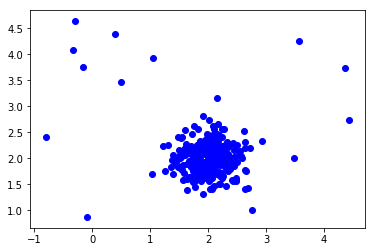

In [14]:
X = make_blob_dataset(300)
plt.scatter(X[:, 0], X[:, 1], color='b');

We now introduce a class that will be used for the solvers.

In [15]:
class svm(object):
    """A class for the dual problem in question 10"""

    def __init__(self, X, C, linear_kernel=True, gaussian_kernel=False):
        self.K = X
        self.n = len(X)
        self.C = C
        
        # We generate kernel functions:
        if linear_kernel:
            self.K = kernel(X, X)
            self.kernel_choice = kernel
            
        if gaussian_kernel:
            self.K = K = rbf_kernel(X, X)
            self.kernel_choice = rbf_kernel
            
    def f(self, mu):  # loss function without regularization
        return 0.5 * mu.T.dot(self.K.dot(mu)) - np.sum(mu)
    
    def g(self, mu):  # regularization function
        if (min(mu) < 0.) | (max(mu) > (self.C / self.n)):
            return np.inf
        else:
            return 0.

    def grad_f(self, mu):
        return self.K.dot(mu) - np.ones(self.n)

    def prox_g(self, mu):
        return np.maximum(0, np.minimum(self.C / self.n, mu))

    def loss(self, mu):
        return self.f(mu) + self.g(mu)
    
    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return np.linalg.norm(self.K, ord = 2) 

 Numerically check loss and gradient

In [16]:
from scipy.optimize import check_grad
d = 300
n = len(X) 
C = 40 #note: we tested different values of C, C = 40 gives good results.
model = svm(X, C)
step = 1. / model.lipschitz_constant()
print("Step = %s" % step)

# Check that the gradient and the loss numerically match
check = check_grad(model.f, model.grad_f, np.random.randn(d))

print("Check_grad = %s" % check)

kernel_choice = model.kernel_choice
print("We use : %s" % kernel_choice)

Step = 0.000403404397417
Check_grad = 0.000495477395061
We use : <function kernel at 0x114777488>


Get a very precise minimum to compute distances to minimum

In [17]:
from scipy.optimize import fmin_l_bfgs_b

mu_init = np.zeros(d)
mu_min, f_min, _ = fmin_l_bfgs_b(model.loss, mu_init, model.grad_f, pgtol=1e-30, factr=1e-30, bounds=[(0, C/n) for i in range(n)])
print("f_min = %s" % f_min)

f_min = -0.215504980686


Before implementing the algorithms (Ista, Fista, CD and L-BFGS), we provide a simple function to be called after each iteration to gather and display a few metrics about the current minimization process

In [18]:
import time
from scipy.linalg import norm

def inspector(loss_fun, mu_real, verbose=True):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    minimum = []
    t0 = time.time()
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    timing = [] 
    def inspector_cl(muk): 
        obj = loss_fun(muk) - f_min 
        minf = loss_fun(muk)
        err = norm(muk - mu_min)
        tim = time.time()-t0
        objectives.append(obj)
        minimum.append(minf)
        errors.append(err)
        timing.append(tim)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), 
                                  ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8), ("%.4e" % tim).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing
    inspector_cl.minf = minimum

    return inspector_cl

In [19]:
# Number of iterations
n_iter = 500

## II. Implementation

### 1. Solver based on the QP function in cvxopt

In [20]:
# Kernel used (there is an option for linear or gaussian kernel in the class "svm" - see above):
K = kernel_choice(X,X)

In [21]:
def ocsvm_solver_v2(K, C):
    n = K.shape[0]
    P = K
    q = -np.ones(n)
    A = np.zeros((1, n))
    b = np.zeros(1)
    lbda = C / n
    mu = qp(P, q, A, b, lbda, verbose=False, Condition=False)
    idx_support = np.where(np.abs(mu) > 1e-05)[0]
    mu_support = mu[idx_support]
   
    return mu_support, idx_support

# Uncomment the following lines when your ocsvm_solver is completed:
mu_support, idx_support = ocsvm_solver_v2(K, C)
print("Number of support vectors: %s" % idx_support.size)

Number of support vectors: 4


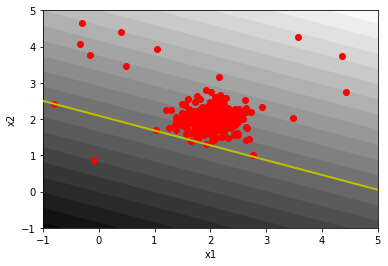

In [22]:
plot_ocsvm(X, mu_support, idx_support, rho=1, kernel=kernel_choice)

### 2. Solver of proximal gradient with and without acceleration

#### Without acceleration

In [23]:
def ista(mu_init, grad_f, prox_g, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    mu = mu_init.copy()
    
    for i in range(n_iter):
        mu = prox_g(mu - step * grad_f(mu)) 
        # Update metrics after each iteration.
        if callback is not None: 
            callback(mu)

    return mu

In [24]:
time0 = time.time()
ista_inspector = inspector(model.loss, mu_min, verbose=True)
mu_ista = ista(mu_init, model.grad_f, model.prox_g, n_iter, step, callback = ista_inspector)
time_ista = time.time() - time0

   it    |   obj    |   err    |   time  
       0 | 1.54e-01 | 1.99e-01 | 8.4782e-04
     100 | 9.27e-02 | 1.70e-01 | 4.7048e-02
     200 | 6.38e-02 | 1.49e-01 | 8.8788e-02
     300 | 4.15e-02 | 1.33e-01 | 1.1531e-01
     400 | 2.25e-02 | 1.22e-01 | 1.4284e-01


In [25]:
print("Total time needed: " + str(time_ista))
min_ista = ista_inspector.obj[-1] + f_min
print("f_min ista: " + str(min_ista))

Total time needed: 0.17024588584899902
f_min ista: -0.207305932698


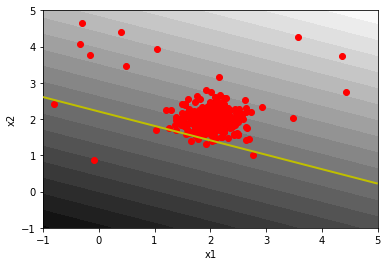

In [26]:
idx_support_ista = np.where(np.abs(mu_ista) > 1e-5)[0]
mu_support_ista = mu_ista[idx_support_ista]
plot_ocsvm(X, mu_support_ista, idx_support_ista, rho=1, kernel=kernel_choice)

#### With acceleration (accelerated batch gradient here)

In [27]:
def fista(mu_init, grad_f, prox_g, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    mu = mu_init.copy()
    y = mu_init.copy()
    t = 1.

    for _ in range(n_iter):
        
        mu_new = prox_g(y - step * grad_f(y))
        t_new = (1 + np.sqrt(1 + 4 * (t**2))) / 2
        y = mu_new + ((t - 1)/ t_new) * (mu_new - mu)
        mu, t = mu_new, t_new
        
        # Update metrics after each iteration.
        if callback is not None: 
            callback(mu)
    return mu

In [28]:
time0 = time.time()
mu_init = np.zeros(d)
fista_inspector = inspector(model.loss, mu_min, verbose=True)
mu_fista = fista(mu_init, model.grad_f, model.prox_g, n_iter, step, callback = fista_inspector)
time_fista = time.time() - time0

   it    |   obj    |   err    |   time  
       0 | 1.54e-01 | 1.99e-01 | 7.9799e-04
     100 | 3.12e-03 | 1.01e-01 | 4.5089e-02
     200 | 1.13e-03 | 6.76e-02 | 8.7816e-02
     300 | 3.70e-04 | 2.78e-02 | 1.3328e-01
     400 | 6.16e-05 | 5.25e-03 | 1.6592e-01


In [29]:
print("Total time needed: " + str(time_fista))
min_fista = fista_inspector.obj[-1] + f_min
print("f_min fista: " + str(min_fista))

Total time needed: 0.1943681240081787
f_min fista: -0.215493997277


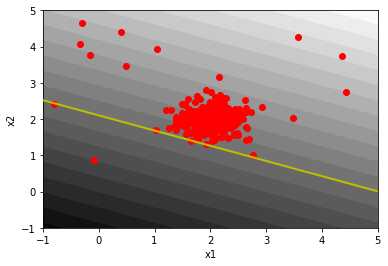

In [30]:
idx_support_fista = np.where(np.abs(mu_fista) > 1e-05)[0]
mu_support_fista = mu_fista[idx_support_fista]
plot_ocsvm(X, mu_support_fista, idx_support_fista, rho=1, kernel=kernel_choice)

### 3. Coordinate descent

$$
(D) : min_{\mu} f(\mu) + g(\mu)
$$



The function f is convex and differentiable. Moreover, g is convex and separable: $g(\mu) = \sum_{i=1}^n g_i(\mu_i)$ with $g_i(\mu_i)=\mathcal{I}_{\Omega}(\mu_i)$


Therefore, we have a composite convex minimization problem : if $f(x)$ is minimized along each coordinate axis, the minimizer is global. In this context, the proximal coordinate descend method can be applied.



For coordinate descent, we need to compute the gradient for every coordinate. 
$$
\nabla f _i = \sum_j K_{ij} \mu_j - 1 = G_iG_i^T - 1 
$$


We can then consider the step for the coordinate descent as follows:
$$
Step_i=\frac{1}{L_i}=\frac{1}{\|\sum_j K_{ij}\|} = \frac{1}{\|G_i\|}
$$


We have to compute prox_g for each coordinate:

In [31]:
from random import *

def cd_prox_g(x, C, n):
    if x > C/n :
        return C/n
    elif x < 0 : 
        return 0
    else:
        return x

We implement now a CD with smart updates. These updates are used to update the gradient with respect to the $i^{th}$ coordinate.

In [32]:
def Coordinate_descent(mu_init, K, prox_g, C, n_iter=100, 
                       verbose=True, callback=None):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 mu^T K mu + 1_n * mu + g(x)
    
    with coordinate descent.
    """
    
    mu = mu_init.copy()
    mu_new = mu_init.copy()
    n = K.shape[0]
        
    L = np.sqrt(np.sum(K*K,axis=0))
   
    Residual = K.dot(mu) - np.ones((n,))
    
    for k in range(n_iter + 1):
        #i = k % n # cyclic rule
        i = randint(0, n-1) # more efficient than the cyclic rule in the quadratic case
        grad_f = Residual[i]
        step = 1 / L[i]
        mu_new[i] = prox_g(mu[i] - step * grad_f, C, n)
            
        Residual += (mu_new[i] - mu[i]) * K[i,:]
        mu = mu_new.copy()
        
        # Update metrics after each iteration.
        if callback is not None: 
            callback(mu)
            
    return mu

In [33]:
time0 = time.time()
n_iter_cd = n * n_iter
mu_init = np.zeros(d)
cd_inspector = inspector(model.loss, mu_min, verbose=True)
mu_cd = Coordinate_descent(mu_init, model.K, cd_prox_g, C, n_iter_cd, callback = cd_inspector)
time_cd = time.time() - time0

   it    |   obj    |   err    |   time  
       0 | 2.09e-01 | 2.00e-01 | 1.5941e-03
     100 | 1.23e-01 | 1.79e-01 | 4.1439e-02
     200 | 1.13e-01 | 1.71e-01 | 7.9555e-02
     300 | 1.04e-01 | 1.67e-01 | 1.1434e-01
     400 | 1.01e-01 | 1.65e-01 | 1.3872e-01
     500 | 9.86e-02 | 1.64e-01 | 1.6496e-01
     600 | 9.59e-02 | 1.63e-01 | 1.8868e-01
     700 | 9.47e-02 | 1.61e-01 | 2.2000e-01
     800 | 7.74e-02 | 1.47e-01 | 2.5197e-01
     900 | 5.93e-02 | 1.36e-01 | 2.7789e-01
    1000 | 4.28e-02 | 1.29e-01 | 3.0321e-01
    1100 | 4.19e-02 | 1.29e-01 | 3.2768e-01
    1200 | 4.07e-02 | 1.27e-01 | 3.5216e-01
    1300 | 3.99e-02 | 1.26e-01 | 3.7616e-01
    1400 | 2.38e-02 | 1.22e-01 | 4.0089e-01
    1500 | 2.31e-02 | 1.22e-01 | 4.2821e-01
    1600 | 2.27e-02 | 1.22e-01 | 4.6395e-01
    1700 | 2.23e-02 | 1.22e-01 | 4.9151e-01
    1800 | 2.19e-02 | 1.22e-01 | 5.1627e-01
    1900 | 2.14e-02 | 1.22e-01 | 5.4085e-01
    2000 | 2.13e-02 | 1.22e-01 | 5.6465e-01
    2100 | 1.97e-02 | 1.22e-01 | 5

   19200 | 3.02e-03 | 9.35e-02 | 5.2174e+00
   19300 | 3.00e-03 | 9.31e-02 | 5.2454e+00
   19400 | 2.98e-03 | 9.31e-02 | 5.2696e+00
   19500 | 2.98e-03 | 9.31e-02 | 5.2939e+00
   19600 | 2.97e-03 | 9.31e-02 | 5.3179e+00
   19700 | 2.96e-03 | 9.32e-02 | 5.3426e+00
   19800 | 2.95e-03 | 9.32e-02 | 5.3668e+00
   19900 | 2.93e-03 | 9.30e-02 | 5.3923e+00
   20000 | 2.92e-03 | 9.30e-02 | 5.4164e+00
   20100 | 2.91e-03 | 9.27e-02 | 5.4528e+00
   20200 | 2.88e-03 | 9.25e-02 | 5.4849e+00
   20300 | 2.83e-03 | 9.22e-02 | 5.5105e+00
   20400 | 2.81e-03 | 9.21e-02 | 5.5348e+00
   20500 | 2.80e-03 | 9.21e-02 | 5.5606e+00
   20600 | 2.79e-03 | 9.21e-02 | 5.5847e+00
   20700 | 2.76e-03 | 9.18e-02 | 5.6093e+00
   20800 | 2.73e-03 | 9.15e-02 | 5.6337e+00
   20900 | 2.73e-03 | 9.16e-02 | 5.6614e+00
   21000 | 2.72e-03 | 9.16e-02 | 5.6972e+00
   21100 | 2.68e-03 | 9.10e-02 | 5.7232e+00
   21200 | 2.66e-03 | 9.03e-02 | 5.7480e+00
   21300 | 2.66e-03 | 9.03e-02 | 5.7721e+00
   21400 | 2.61e-03 | 8.97e-02 |

   38400 | 1.73e-03 | 7.65e-02 | 1.0327e+01
   38500 | 1.73e-03 | 7.65e-02 | 1.0366e+01
   38600 | 1.73e-03 | 7.65e-02 | 1.0395e+01
   38700 | 1.72e-03 | 7.65e-02 | 1.0420e+01
   38800 | 1.72e-03 | 7.65e-02 | 1.0444e+01
   38900 | 1.72e-03 | 7.64e-02 | 1.0470e+01
   39000 | 1.72e-03 | 7.62e-02 | 1.0495e+01
   39100 | 1.71e-03 | 7.62e-02 | 1.0519e+01
   39200 | 1.71e-03 | 7.61e-02 | 1.0544e+01
   39300 | 1.71e-03 | 7.61e-02 | 1.0569e+01
   39400 | 1.71e-03 | 7.60e-02 | 1.0608e+01
   39500 | 1.71e-03 | 7.59e-02 | 1.0636e+01
   39600 | 1.71e-03 | 7.59e-02 | 1.0660e+01
   39700 | 1.71e-03 | 7.59e-02 | 1.0685e+01
   39800 | 1.71e-03 | 7.59e-02 | 1.0709e+01
   39900 | 1.70e-03 | 7.56e-02 | 1.0734e+01
   40000 | 1.70e-03 | 7.56e-02 | 1.0759e+01
   40100 | 1.70e-03 | 7.56e-02 | 1.0791e+01
   40200 | 1.70e-03 | 7.56e-02 | 1.0821e+01
   40300 | 1.70e-03 | 7.56e-02 | 1.0845e+01
   40400 | 1.70e-03 | 7.56e-02 | 1.0870e+01
   40500 | 1.69e-03 | 7.54e-02 | 1.0895e+01
   40600 | 1.69e-03 | 7.54e-02 |

   57200 | 1.34e-03 | 6.45e-02 | 1.5429e+01
   57300 | 1.34e-03 | 6.45e-02 | 1.5461e+01
   57400 | 1.33e-03 | 6.43e-02 | 1.5488e+01
   57500 | 1.33e-03 | 6.43e-02 | 1.5512e+01
   57600 | 1.33e-03 | 6.43e-02 | 1.5536e+01
   57700 | 1.33e-03 | 6.43e-02 | 1.5561e+01
   57800 | 1.32e-03 | 6.43e-02 | 1.5586e+01
   57900 | 1.32e-03 | 6.43e-02 | 1.5610e+01
   58000 | 1.32e-03 | 6.41e-02 | 1.5638e+01
   58100 | 1.31e-03 | 6.39e-02 | 1.5674e+01
   58200 | 1.31e-03 | 6.39e-02 | 1.5700e+01
   58300 | 1.31e-03 | 6.37e-02 | 1.5725e+01
   58400 | 1.30e-03 | 6.35e-02 | 1.5749e+01
   58500 | 1.30e-03 | 6.35e-02 | 1.5775e+01
   58600 | 1.30e-03 | 6.35e-02 | 1.5801e+01
   58700 | 1.30e-03 | 6.34e-02 | 1.5826e+01
   58800 | 1.30e-03 | 6.34e-02 | 1.5858e+01
   58900 | 1.30e-03 | 6.33e-02 | 1.5888e+01
   59000 | 1.29e-03 | 6.32e-02 | 1.5913e+01
   59100 | 1.29e-03 | 6.32e-02 | 1.5938e+01
   59200 | 1.29e-03 | 6.31e-02 | 1.5964e+01
   59300 | 1.29e-03 | 6.31e-02 | 1.5988e+01
   59400 | 1.29e-03 | 6.30e-02 |

   76600 | 9.09e-04 | 5.13e-02 | 2.0583e+01
   76700 | 9.09e-04 | 5.13e-02 | 2.0621e+01
   76800 | 9.06e-04 | 5.12e-02 | 2.0646e+01
   76900 | 9.06e-04 | 5.12e-02 | 2.0670e+01
   77000 | 9.06e-04 | 5.12e-02 | 2.0695e+01
   77100 | 9.01e-04 | 5.12e-02 | 2.0719e+01
   77200 | 8.98e-04 | 5.10e-02 | 2.0744e+01
   77300 | 8.98e-04 | 5.10e-02 | 2.0768e+01
   77400 | 8.98e-04 | 5.10e-02 | 2.0796e+01
   77500 | 8.89e-04 | 5.08e-02 | 2.0828e+01
   77600 | 8.89e-04 | 5.08e-02 | 2.0854e+01
   77700 | 8.89e-04 | 5.08e-02 | 2.0880e+01
   77800 | 8.89e-04 | 5.08e-02 | 2.0905e+01
   77900 | 8.83e-04 | 5.06e-02 | 2.0930e+01
   78000 | 8.82e-04 | 5.06e-02 | 2.0955e+01
   78100 | 8.82e-04 | 5.06e-02 | 2.0979e+01
   78200 | 8.81e-04 | 5.06e-02 | 2.1008e+01
   78300 | 8.70e-04 | 5.03e-02 | 2.1041e+01
   78400 | 8.67e-04 | 5.01e-02 | 2.1065e+01
   78500 | 8.67e-04 | 5.01e-02 | 2.1090e+01
   78600 | 8.59e-04 | 4.98e-02 | 2.1115e+01
   78700 | 8.59e-04 | 4.98e-02 | 2.1139e+01
   78800 | 8.56e-04 | 4.98e-02 |

   95500 | 6.65e-04 | 4.26e-02 | 2.5557e+01
   95600 | 6.64e-04 | 4.25e-02 | 2.5591e+01
   95700 | 6.63e-04 | 4.24e-02 | 2.5619e+01
   95800 | 6.61e-04 | 4.24e-02 | 2.5644e+01
   95900 | 6.59e-04 | 4.23e-02 | 2.5669e+01
   96000 | 6.59e-04 | 4.23e-02 | 2.5695e+01
   96100 | 6.58e-04 | 4.23e-02 | 2.5719e+01
   96200 | 6.56e-04 | 4.22e-02 | 2.5744e+01
   96300 | 6.56e-04 | 4.22e-02 | 2.5768e+01
   96400 | 6.56e-04 | 4.22e-02 | 2.5793e+01
   96500 | 6.53e-04 | 4.21e-02 | 2.5833e+01
   96600 | 6.50e-04 | 4.19e-02 | 2.5860e+01
   96700 | 6.49e-04 | 4.19e-02 | 2.5884e+01
   96800 | 6.49e-04 | 4.19e-02 | 2.5909e+01
   96900 | 6.49e-04 | 4.19e-02 | 2.5933e+01
   97000 | 6.49e-04 | 4.19e-02 | 2.5958e+01
   97100 | 6.49e-04 | 4.19e-02 | 2.5982e+01
   97200 | 6.49e-04 | 4.19e-02 | 2.6006e+01
   97300 | 6.49e-04 | 4.19e-02 | 2.6031e+01
   97400 | 6.49e-04 | 4.19e-02 | 2.6067e+01
   97500 | 6.49e-04 | 4.19e-02 | 2.6094e+01
   97600 | 6.49e-04 | 4.19e-02 | 2.6119e+01
   97700 | 6.49e-04 | 4.18e-02 |

  114600 | 4.76e-04 | 3.41e-02 | 3.0556e+01
  114700 | 4.76e-04 | 3.41e-02 | 3.0590e+01
  114800 | 4.75e-04 | 3.40e-02 | 3.0617e+01
  114900 | 4.72e-04 | 3.39e-02 | 3.0642e+01
  115000 | 4.70e-04 | 3.38e-02 | 3.0668e+01
  115100 | 4.69e-04 | 3.38e-02 | 3.0692e+01
  115200 | 4.67e-04 | 3.37e-02 | 3.0717e+01
  115300 | 4.67e-04 | 3.37e-02 | 3.0741e+01
  115400 | 4.63e-04 | 3.35e-02 | 3.0772e+01
  115500 | 4.62e-04 | 3.34e-02 | 3.0806e+01
  115600 | 4.62e-04 | 3.34e-02 | 3.0830e+01
  115700 | 4.62e-04 | 3.34e-02 | 3.0855e+01
  115800 | 4.62e-04 | 3.34e-02 | 3.0880e+01
  115900 | 4.59e-04 | 3.34e-02 | 3.0904e+01
  116000 | 4.58e-04 | 3.33e-02 | 3.0929e+01
  116100 | 4.57e-04 | 3.33e-02 | 3.0953e+01
  116200 | 4.56e-04 | 3.33e-02 | 3.0981e+01
  116300 | 4.56e-04 | 3.33e-02 | 3.1012e+01
  116400 | 4.56e-04 | 3.33e-02 | 3.1037e+01
  116500 | 4.56e-04 | 3.33e-02 | 3.1061e+01
  116600 | 4.56e-04 | 3.33e-02 | 3.1085e+01
  116700 | 4.56e-04 | 3.33e-02 | 3.1110e+01
  116800 | 4.55e-04 | 3.33e-02 |

  133900 | 3.04e-04 | 2.69e-02 | 3.5646e+01
  134000 | 3.04e-04 | 2.69e-02 | 3.5679e+01
  134100 | 3.04e-04 | 2.68e-02 | 3.5705e+01
  134200 | 3.04e-04 | 2.68e-02 | 3.5730e+01
  134300 | 3.04e-04 | 2.68e-02 | 3.5755e+01
  134400 | 3.03e-04 | 2.67e-02 | 3.5779e+01
  134500 | 3.03e-04 | 2.67e-02 | 3.5804e+01
  134600 | 3.03e-04 | 2.67e-02 | 3.5829e+01
  134700 | 3.03e-04 | 2.67e-02 | 3.5858e+01
  134800 | 3.02e-04 | 2.67e-02 | 3.5893e+01
  134900 | 3.02e-04 | 2.67e-02 | 3.5918e+01
  135000 | 3.02e-04 | 2.67e-02 | 3.5943e+01
  135100 | 3.01e-04 | 2.66e-02 | 3.5968e+01
  135200 | 3.01e-04 | 2.65e-02 | 3.5992e+01
  135300 | 3.00e-04 | 2.65e-02 | 3.6018e+01
  135400 | 3.00e-04 | 2.65e-02 | 3.6043e+01
  135500 | 3.00e-04 | 2.65e-02 | 3.6072e+01
  135600 | 3.00e-04 | 2.65e-02 | 3.6103e+01
  135700 | 3.00e-04 | 2.65e-02 | 3.6128e+01
  135800 | 3.00e-04 | 2.64e-02 | 3.6153e+01
  135900 | 2.98e-04 | 2.63e-02 | 3.6178e+01
  136000 | 2.98e-04 | 2.63e-02 | 3.6203e+01
  136100 | 2.98e-04 | 2.63e-02 |

In [34]:
print("Total time needed: " + str(time_cd))
min_cd = cd_inspector.obj[-1] + f_min
print("f_min cd: " + str(min_cd))

Total time needed: 39.90678787231445
f_min cd: -0.215263690543


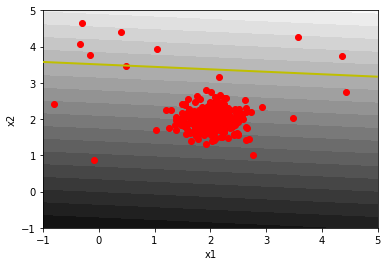

In [35]:
idx_support_cd = np.where(np.abs(mu_cd) > 1e-5)[0]
mu_support_cd = mu_ista[idx_support_cd]
plot_ocsvm(X, mu_support_cd, idx_support_cd, rho=1, kernel=kernel_choice)

### 4. L-BFGS-B solver using scipy.optimize.fmin_l_bfgs_b

In [36]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

time0 = time.time()
mu_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, mu_min, verbose=True)
mu_bfgs, _, _ = fmin_l_bfgs_b(model.loss, mu_init, model.grad_f, maxiter=n_iter, callback=bfgs_inspector,
                              bounds=[(0, C/n) for i in range(n)])
time_lbfgs = time.time() - time0

   it    |   obj    |   err    |   time  
       0 | 1.54e-01 | 1.99e-01 | 3.9144e-03


In [37]:
print("Total time needed: " + str(time_lbfgs))
min_lbfgs = bfgs_inspector.obj[-1] + f_min
print("f_min lbfgs: " + str(min_lbfgs))

Total time needed: 0.05011701583862305
f_min lbfgs: -0.215142781593


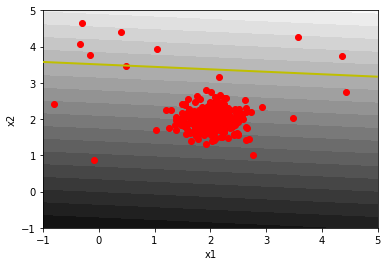

In [38]:
idx_support_lbfgs= np.where(np.abs(mu_bfgs) > 1e-05)[0]
mu_support_lbfgs = mu_ista[idx_support_lbfgs]
plot_ocsvm(X, mu_support_lbfgs, idx_support_lbfgs, rho=1, kernel=kernel_choice)

# III. Comparison


We can see that, with 500 iterations, all solvers converge approximatly towards the same minimum:

In [39]:
print("f_min ista = " + str(min_ista))
print("f_min fista = " + str(min_fista))
print("f_min cd = " + str(min_cd))
print("f_min lbfgs = " + str(min_lbfgs))

f_min ista = -0.207305932698
f_min fista = -0.215493997277
f_min cd = -0.215263690543
f_min lbfgs = -0.215142781593


### A first numerical comparison of the solvers

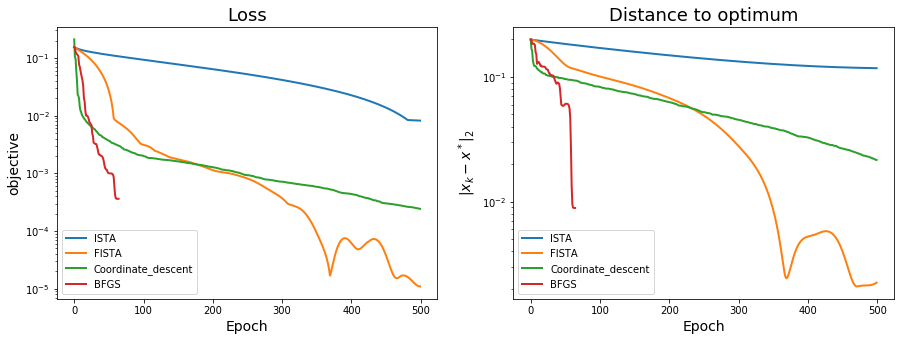

In [40]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cd_inspector, bfgs_inspector]
solvers = ["ISTA", "FISTA", "Coordinate_descent", "BFGS"]

scale_cd = [n * i for i in range (n_iter)]

for insp in inspectors:
    if insp == cd_inspector:
        objective = [insp.obj[i] for i in scale_cd]
        plt.semilogy(objective, lw=2)
    else:
        plt.semilogy(insp.obj, lw=2)
    
    #plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)
plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    if insp == cd_inspector:
        error=[insp.err[i] for i in scale_cd]
        plt.semilogy(error, lw=2)
    else:
        plt.semilogy(insp.err, lw=2)
       
    #plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
plt.legend(solvers);



- **Cost per iteration:**


The cost of the computation of $\nabla f$ is n times the cost of the computation of $\nabla f_i$. In order to compare the two algorithms based on the same complexity, we have changed the scale of the coordinate descent in order to plot one iteration for each n computation of $\nabla f_i$.


- **Rate of convergence (in terms of number of epochs):**

With such a conditioning of the problem, we can clearly see that the rate of convergence of the Coordinate descent algorithm is particularly large at the beginning. After a few iterations, the rate of convergence of the L-BFGS algorithm becomes faster. Furthermore, ISTA converges slowly and does not vary much from the inital value after 500 iterations: this algorithm is the less precise. 



### Comparison in terms of computation time:

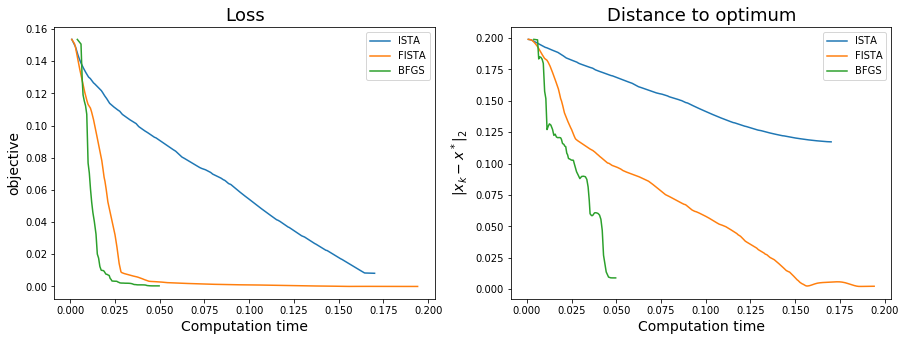

In [41]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "BFGS"]

for insp in inspectors:
    plt.plot(insp.timing, insp.obj)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Computation time", fontsize=14)
    plt.ylabel("objective", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)
for insp in inspectors:
    plt.plot(insp.timing, insp.err)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Computation time", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

In [42]:
print("Total time needed for Ista (500 iterations): " + str(time_ista))
print("Total time needed for Fista (500 iterations): " + str(time_fista))
print("Total time needed for CD (500*300 iterations): " + str(time_cd))
print("Total time needed for CD (normalized for 500 iterations): " + str(time_cd/300))
print("Total time needed for L-BFGS (500 iterations): " + str(time_lbfgs))

Total time needed for Ista (500 iterations): 0.17024588584899902
Total time needed for Fista (500 iterations): 0.1943681240081787
Total time needed for CD (500*300 iterations): 39.90678787231445
Total time needed for CD (normalized for 500 iterations): 0.1330226262410482
Total time needed for L-BFGS (500 iterations): 0.05011701583862305


- **Running time:**

We cannot directly compare the total computational time of the CD algorithm with the running time of the other algorithms since the CD algorithm is implemented with much more iterations than the other algorithms.

We observe that the L-BFGS algorithm is the best algorithm in terms of computation time. ISTA has a similar running time as FISTA, whereas CD (normalized for 500 iterations) has a lower running time. 





To conclude, within the context used in question 12 (conditioning of the problem, linear kernel, smoothness constant, etc.), the L-BFGS algorithm outperforms the other algorithms (CD, ISTA and FISTA) in terms of both running time and number of iterations. Also, ISTA is the less efficient algorithm (largest error, running time). 


## IV. Conditioning of the problem

We now change the conditioning of our problem in order to see if the previous conclusions are impacted.


### 1. Value of C

C is the regularization parameter. For large values of C, the optimization will choose a smaller number of support vectors and thus a smaller margion hyperplane. There is a risk of overfitting. We should have tuned the value of C (with a k-fold cross validation) to obtain the best results.

However, we tested differents values of C (0,1, 1, 10, 40, 100, 500, 1000) and taking C=40 seemed to be the best compromise. However, the previous conclusion (see above) is not impacted when varying the value of C.


### 2. Using Gaussian kernel




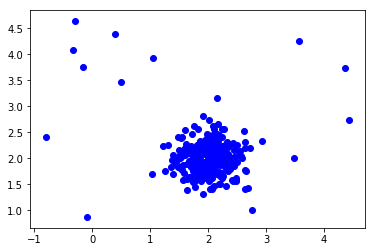

In [43]:
d = 300
X = make_blob_dataset(d)
plt.scatter(X[:, 0], X[:, 1], color='b');
n = len(X)

In [44]:
C = 40
model = svm(X, C, linear_kernel=False, gaussian_kernel=True)
step = 1. / model.lipschitz_constant()
print("Step = %s" % step)

# Check that the gradient and the loss numerically match
check = check_grad(model.f, model.grad_f, np.random.randn(d))
print("Check_grad = %s" % check)

kernel_choice = model.kernel_choice
print("We use : %s" % kernel_choice)

mu_init = np.zeros(d)
mu_min, f_min, _ = fmin_l_bfgs_b(model.loss, mu_init, model.grad_f, pgtol=1e-30, factr=1e-30, bounds=[(0, C/n) for i in range(n)])
print("f_min = %s" % f_min)

Step = 0.00382375958597
Check_grad = 9.89769538004e-05
We use : <function rbf_kernel at 0x11f8ba8c8>
f_min = -1.61830434318


Number of support vectors: 21


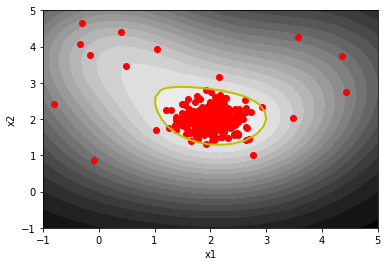

In [45]:
# Kernel used (there is an option for linear or gaussian kernel in the class "svm" - see above):
K = kernel_choice(X,X)
# Uncomment the following lines when your ocsvm_solver is completed:
mu_support, idx_support = ocsvm_solver_v2(K, C)
print("Number of support vectors: %s" % idx_support.size)
plot_ocsvm(X, mu_support, idx_support, rho=1, kernel=kernel_choice)

In [46]:
# ISTA
time0 = time.time()
ista_inspector = inspector(model.loss, mu_min, verbose=False)
mu_ista = ista(mu_init, model.grad_f, model.prox_g, n_iter, step, callback = ista_inspector)
time_ista = time.time() - time0
idx_support_ista = np.where(np.abs(mu_ista) > 1e-5)[0]
mu_support_ista = mu_ista[idx_support_ista]
# FISTA
time0 = time.time()
mu_init = np.zeros(d)
fista_inspector = inspector(model.loss, mu_min, verbose=False)
mu_fista = fista(mu_init, model.grad_f, model.prox_g, n_iter, step, callback = fista_inspector)
time_fista = time.time() - time0
idx_support_fista = np.where(np.abs(mu_fista) > 1e-5)[0]
mu_support_fista = mu_fista[idx_support_fista]
# CG
time0 = time.time()
n_iter_cd = n * n_iter
mu_init = np.zeros(d)
cd_inspector = inspector(model.loss, mu_min, verbose=False)
mu_cd = Coordinate_descent(mu_init, model.K, cd_prox_g, C, n_iter_cd, callback = cd_inspector)
time_cd = time.time() - time0
idx_support_cd = np.where(np.abs(mu_cd) > 1e-5)[0]
mu_support_cd = mu_cd[idx_support_cd]
# LBFGS
time0 = time.time()
mu_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, mu_min, verbose=False)
mu_bfgs, _, _ = fmin_l_bfgs_b(model.loss, mu_init, model.grad_f, maxiter=n_iter, callback=bfgs_inspector,
                              bounds=[(0, C/n) for i in range(n)])
time_lbfgs = time.time() - time0
idx_support_lbfgs = np.where(np.abs(mu_bfgs) > 1e-5)[0]
mu_support_lbfgs = mu_bfgs[idx_support_lbfgs]

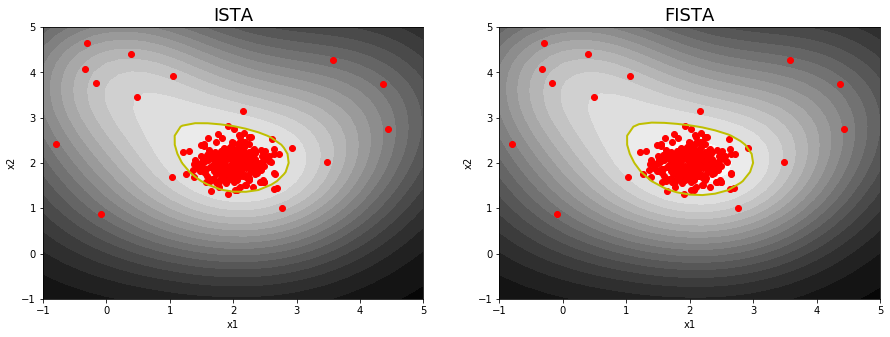

In [47]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("ISTA", fontsize=18)
plot_ocsvm(X, mu_support_ista, idx_support_ista, rho=1, kernel=kernel_choice)
plt.subplot(1, 2, 2)
plt.title("FISTA", fontsize=18)
plot_ocsvm(X, mu_support_fista, idx_support_fista, rho=1, kernel=kernel_choice)

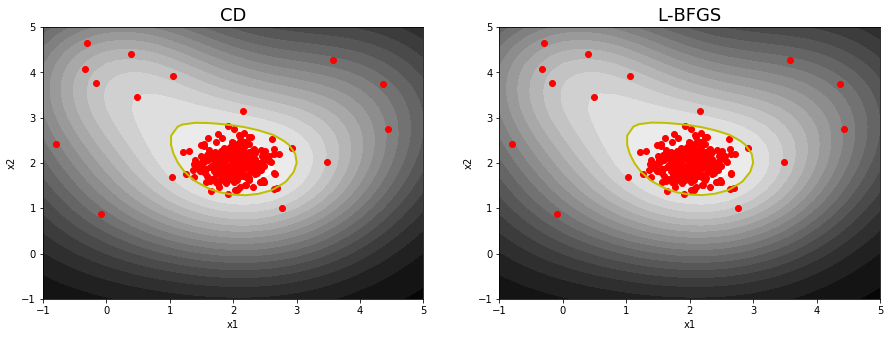

In [48]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("CD", fontsize=18)
plot_ocsvm(X, mu_support_cd, idx_support_cd, rho=1, kernel=kernel_choice)
plt.subplot(1, 2, 2)
plt.title("L-BFGS", fontsize=18)
plot_ocsvm(X, mu_support_lbfgs, idx_support_lbfgs, rho=1, kernel=kernel_choice)

In [49]:
print("f_min ista = " + str(min_ista))
print("f_min fista = " + str(min_fista))
print("f_min cd = " + str(min_cd))
print("f_min lbfgs = " + str(min_lbfgs))

f_min ista = -0.207305932698
f_min fista = -0.215493997277
f_min cd = -0.215263690543
f_min lbfgs = -0.215142781593


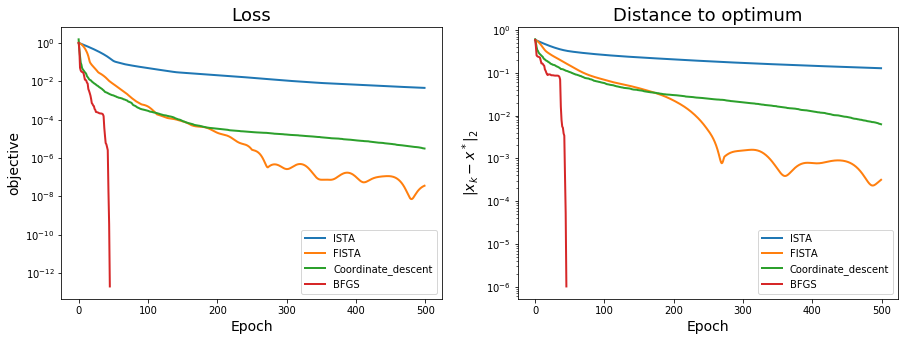

In [50]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cd_inspector, bfgs_inspector]
solvers = ["ISTA", "FISTA", "Coordinate_descent", "BFGS"]

scale_cd = [n * i for i in range (n_iter)]

for insp in inspectors:
    if insp == cd_inspector:
        objective = [insp.obj[i] for i in scale_cd]
        plt.semilogy(objective, lw=2)
    else:
        plt.semilogy(insp.obj, lw=2)
    
    #plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)
plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    if insp == cd_inspector:
        error=[insp.err[i] for i in scale_cd]
        plt.semilogy(error, lw=2)
    else:
        plt.semilogy(insp.err, lw=2)
       
    #plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
plt.legend(solvers);

In [51]:
print("Total time needed for Ista (500 iterations): " + str(time_ista))
print("Total time needed for Fista (500 iterations): " + str(time_fista))
print("Total time needed for CD (500*300 iterations): " + str(time_cd))
print("Total time needed for CD (normalized for 500 iterations): " + str(time_cd/300))
print("Total time needed for L-BFGS (500 iterations): " + str(time_lbfgs))

Total time needed for Ista (500 iterations): 0.13893389701843262
Total time needed for Fista (500 iterations): 0.1415848731994629
Total time needed for CD (500*300 iterations): 40.612184047698975
Total time needed for CD (normalized for 500 iterations): 0.13537394682566325
Total time needed for L-BFGS (500 iterations): 0.023611068725585938


- We obtain similar results as before (with a linear kernel) in terms of speed of convergence: L-BFGS outperforms the other algorithms. However, the classification graphs give better results (the dense region is better separated from the outliers). The boundary between normal samples and outliers may be non linear.

- The graphs obtained show that the algorithms do converge to the minimum, and the separation between the data and the outliers is as precise as the one returned by the ocsvm solver, which is quite good. 

- The classification graphs obtained are quite similar no matter what algorithm we are using. Let's try to make it a little bit harder and to increase the contamination rate.

### 3. Increasing the contamination rate 

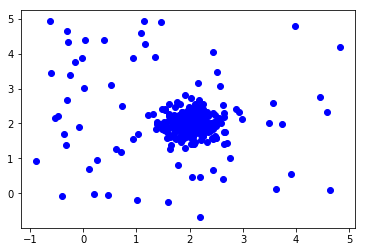

In [52]:
d = 300
X = make_blob_dataset(d, contamination= 0.2)
plt.scatter(X[:, 0], X[:, 1], color='b');
n = len(X)

In [53]:
C = 10 # explanation in the next comments
model = svm(X, C, linear_kernel=False, gaussian_kernel=True)
step = 1. / model.lipschitz_constant()
print("Step = %s" % step)

# Check that the gradient and the loss numerically match
check = check_grad(model.f, model.grad_f, np.random.randn(d))
print("Check_grad = %s" % check)

kernel_choice = model.kernel_choice
print("We use : %s" % kernel_choice)

mu_init = np.zeros(d)
mu_min, f_min, _ = fmin_l_bfgs_b(model.loss, mu_init, model.grad_f, pgtol=1e-30, factr=1e-30, bounds=[(0, C/n) for i in range(n)])
print("f_min = %s" % f_min)

Step = 0.00439732969843
Check_grad = 2.51478597985e-05
We use : <function rbf_kernel at 0x11f8ba8c8>
f_min = -1.66532869432


Number of support vectors: 78


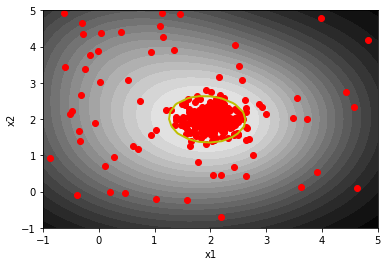

In [54]:
# Kernel used (there is an option for linear or gaussian kernel in the class "svm" - see above):
K = kernel_choice(X,X)
# Uncomment the following lines when your ocsvm_solver is completed:
mu_support, idx_support = ocsvm_solver_v2(K, C)
print("Number of support vectors: %s" % idx_support.size)
plot_ocsvm(X, mu_support, idx_support, rho=1, kernel=kernel_choice)

In [55]:
# ISTA
time0 = time.time()
ista_inspector = inspector(model.loss, mu_min, verbose=False)
mu_ista = ista(mu_init, model.grad_f, model.prox_g, n_iter, step, callback = ista_inspector)
time_ista = time.time() - time0
idx_support_ista = np.where(np.abs(mu_ista) > 1e-5)[0]
mu_support_ista = mu_ista[idx_support_ista]
# FISTA
time0 = time.time()
mu_init = np.zeros(d)
fista_inspector = inspector(model.loss, mu_min, verbose=False)
mu_fista = fista(mu_init, model.grad_f, model.prox_g, n_iter, step, callback = fista_inspector)
time_fista = time.time() - time0
idx_support_fista = np.where(np.abs(mu_fista) > 1e-5)[0]
mu_support_fista = mu_fista[idx_support_fista]
# CG
time0 = time.time()
n_iter_cd = n * n_iter
mu_init = np.zeros(d)
cd_inspector = inspector(model.loss, mu_min, verbose=False)
mu_cd = Coordinate_descent(mu_init, model.K, cd_prox_g, C, n_iter_cd, callback = cd_inspector)
time_cd = time.time() - time0
idx_support_cd = np.where(np.abs(mu_cd) > 1e-5)[0]
mu_support_cd = mu_cd[idx_support_cd]
# LBFGS
time0 = time.time()
mu_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, mu_min, verbose=False)
mu_bfgs, _, _ = fmin_l_bfgs_b(model.loss, mu_init, model.grad_f, maxiter=n_iter, callback=bfgs_inspector,
                              bounds=[(0, C/n) for i in range(n)])
time_lbfgs = time.time() - time0
idx_support_lbfgs = np.where(np.abs(mu_bfgs) > 1e-5)[0]
mu_support_lbfgs = mu_bfgs[idx_support_lbfgs]

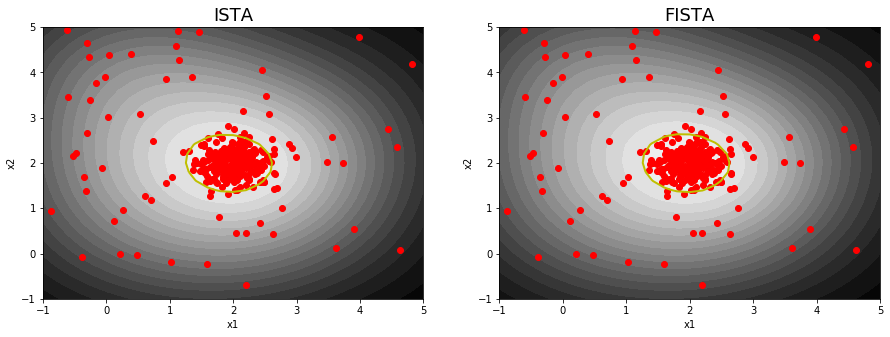

In [56]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("ISTA", fontsize=18)
plot_ocsvm(X, mu_support_ista, idx_support_ista, rho=1, kernel=kernel_choice)
plt.subplot(1, 2, 2)
plt.title("FISTA", fontsize=18)
plot_ocsvm(X, mu_support_fista, idx_support_fista, rho=1, kernel=kernel_choice)

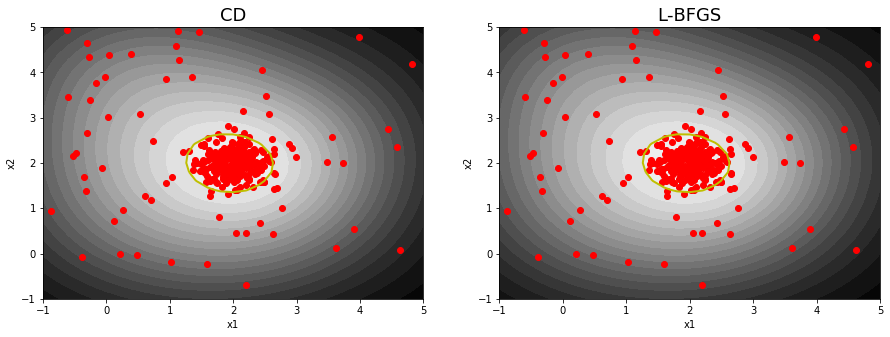

In [57]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("CD", fontsize=18)
plot_ocsvm(X, mu_support_cd, idx_support_cd, rho=1, kernel=kernel_choice)
plt.subplot(1, 2, 2)
plt.title("L-BFGS", fontsize=18)
plot_ocsvm(X, mu_support_lbfgs, idx_support_lbfgs, rho=1, kernel=kernel_choice)

In [58]:
print("f_min ista = " + str(min_ista))
print("f_min fista = " + str(min_fista))
print("f_min cd = " + str(min_cd))
print("f_min lbfgs = " + str(min_lbfgs))

f_min ista = -0.207305932698
f_min fista = -0.215493997277
f_min cd = -0.215263690543
f_min lbfgs = -0.215142781593


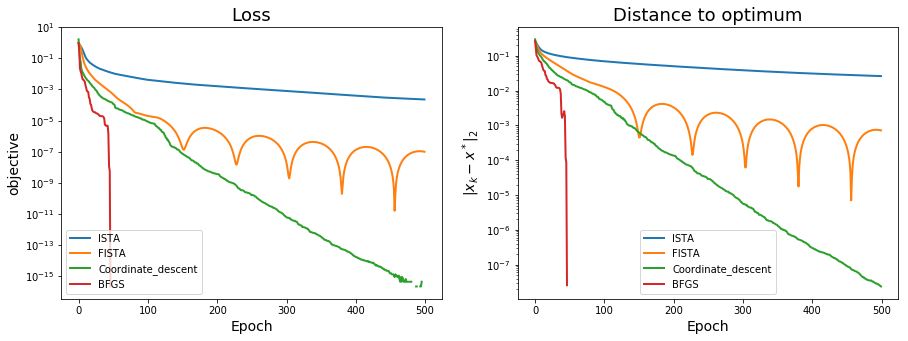

In [59]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cd_inspector, bfgs_inspector]
solvers = ["ISTA", "FISTA", "Coordinate_descent", "BFGS"]

scale_cd = [n * i for i in range (n_iter)]

for insp in inspectors:
    if insp == cd_inspector:
        objective = [insp.obj[i] for i in scale_cd]
        plt.semilogy(objective, lw=2)
    else:
        plt.semilogy(insp.obj, lw=2)
    
    #plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)
plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    if insp == cd_inspector:
        error=[insp.err[i] for i in scale_cd]
        plt.semilogy(error, lw=2)
    else:
        plt.semilogy(insp.err, lw=2)
       
    #plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
plt.legend(solvers);

In [60]:
print("Total time needed for Ista (500 iterations): " + str(time_ista))
print("Total time needed for Fista (500 iterations): " + str(time_fista))
print("Total time needed for CD (500*300 iterations): " + str(time_cd))
print("Total time needed for CD (normalized for 500 iterations): " + str(time_cd/300))
print("Total time needed for L-BFGS (500 iterations): " + str(time_lbfgs))

Total time needed for Ista (500 iterations): 0.16072773933410645
Total time needed for Fista (500 iterations): 0.17572402954101562
Total time needed for CD (500*300 iterations): 48.16186189651489
Total time needed for CD (normalized for 500 iterations): 0.16053953965504963
Total time needed for L-BFGS (500 iterations): 0.0641322135925293


#### Using C = 40 (not depicted here) : 
When keeping the same value of C as before, we get the following results:
- Increasing the contamination of the dataset makes it harder for the algorithms to find the right separation between the data and the outliers. However, we still do not see any improvements nor changes in the graphs of the algorithms, this means that even though the algorithms are different and does not converge with the same speed, the minimum reached is approximatively the same for all of them.

- The algorithms perform poorly. Indeed, when increasing the contamination of the data set, the separation between the outliers and the rest of the data gets blurred. We can see here that the limit drawn is too unrestrictive.


#### Using C = 10 (depicted above) : 

Since those results are quite bad, we decided to restrict more our problem and shrink C to 10. Using this value, we get the following results:

- The algorithms converge to the right minimum, the limit separating both the outliers and the rest of the data is restrictive taking into acounting data regardless of all the outliers. 

- When decreasing the value of C, coordinate descent decreases in less epochs than FISTA and ISTA. It is the one getting the closest to the minimum.

$\Rightarrow$ When the data is noisy we have to modify the constraints of the problem such that $\mu$ is more constrained, as it happens setting C to a smaller value.

## V. Test on medium scale datasets

The previous results are for a small dataset (n=300). We now increase the size of the dataset in order to have a medium scale dataset.

We use C=40 and Gaussian Kernel.



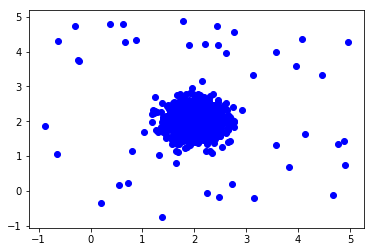

In [61]:
d = 1000
X = make_blob_dataset(d)
plt.scatter(X[:, 0], X[:, 1], color='b');
n = len(X)

In [62]:
C = 40 
model = svm(X, C, linear_kernel=False, gaussian_kernel=True)
step = 1. / model.lipschitz_constant()
print("Step = %s" % step)

# Check that the gradient and the loss numerically match
check = check_grad(model.f, model.grad_f, np.random.randn(d))
print("Check_grad = %s" % check)
kernel_choice = model.kernel_choice
print("We use : %s" % kernel_choice)

mu_init = np.zeros(d)
mu_min, f_min, _ = fmin_l_bfgs_b(model.loss, mu_init, model.grad_f, pgtol=1e-30, factr=1e-30, bounds=[(0, C/n) for i in range(n)])
print("f_min = %s" % f_min)

Step = 0.00114760557589
Check_grad = 0.000349215451011
We use : <function rbf_kernel at 0x11f8ba8c8>
f_min = -1.72241133721


In [63]:
K = kernel_choice(X,X)

In [64]:
mu_support, idx_support = ocsvm_solver_v2(K, C)
print("Number of support vectors: %s" % idx_support.size)

Number of support vectors: 68


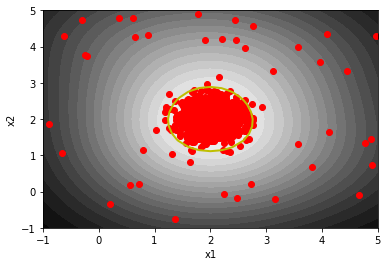

In [65]:
plot_ocsvm(X, mu_support, idx_support, rho=1, kernel=kernel_choice)

In [66]:
# ISTA
time0 = time.time()
ista_inspector = inspector(model.loss, mu_min, verbose=False)
mu_ista = ista(mu_init, model.grad_f, model.prox_g, n_iter, step, callback = ista_inspector)
time_ista = time.time() - time0
idx_support_ista = np.where(np.abs(mu_ista) > 1e-5)[0]
mu_support_ista = mu_ista[idx_support_ista]
# FISTA
time0 = time.time()
mu_init = np.zeros(d)
fista_inspector = inspector(model.loss, mu_min, verbose=False)
mu_fista = fista(mu_init, model.grad_f, model.prox_g, n_iter, step, callback = fista_inspector)
time_fista = time.time() - time0
idx_support_fista = np.where(np.abs(mu_fista) > 1e-5)[0]
mu_support_fista = mu_fista[idx_support_fista]
# CG
time0 = time.time()
n_iter_cd = n * n_iter
mu_init = np.zeros(d)
cd_inspector = inspector(model.loss, mu_min, verbose=False)
mu_cd = Coordinate_descent(mu_init, model.K, cd_prox_g, C, n_iter_cd, callback = cd_inspector)
time_cd = time.time() - time0
idx_support_cd = np.where(np.abs(mu_cd) > 1e-5)[0]
mu_support_cd = mu_cd[idx_support_cd]
# LBFGS
time0 = time.time()
mu_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, mu_min, verbose=False)
mu_bfgs, _, _ = fmin_l_bfgs_b(model.loss, mu_init, model.grad_f, maxiter=n_iter, callback=bfgs_inspector,
                              bounds=[(0, C/n) for i in range(n)])
time_lbfgs = time.time() - time0
idx_support_lbfgs = np.where(np.abs(mu_bfgs) > 1e-5)[0]
mu_support_lbfgs = mu_bfgs[idx_support_lbfgs]

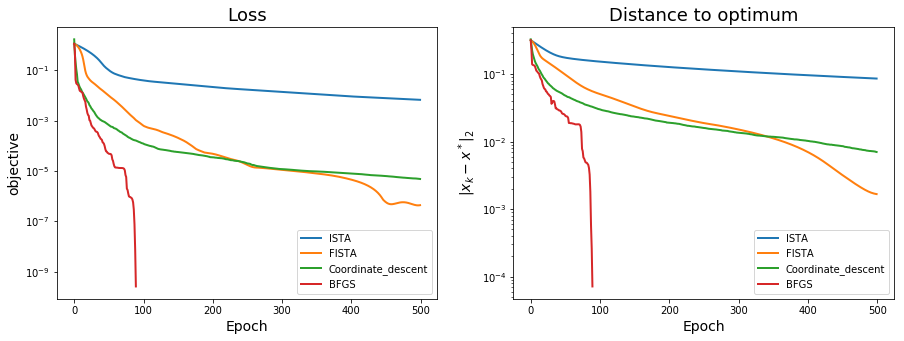

In [67]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cd_inspector, bfgs_inspector]
solvers = ["ISTA", "FISTA", "Coordinate_descent", "BFGS"]

scale_cd = [n * i for i in range (n_iter)]

for insp in inspectors:
    if insp == cd_inspector:
        objective = [insp.obj[i] for i in scale_cd]
        plt.semilogy(objective, lw=2)
    else:
        plt.semilogy(insp.obj, lw=2)
    
    #plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)
plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    if insp == cd_inspector:
        error=[insp.err[i] for i in scale_cd]
        plt.semilogy(error, lw=2)
    else:
        plt.semilogy(insp.err, lw=2)
       
    #plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
plt.legend(solvers);

In [68]:
print("f_min ista = " + str(min_ista))
print("f_min fista = " + str(min_fista))
print("f_min cd = " + str(min_cd))
print("f_min lbfgs = " + str(min_lbfgs))

f_min ista = -0.207305932698
f_min fista = -0.215493997277
f_min cd = -0.215263690543
f_min lbfgs = -0.215142781593


In [69]:
print("Total time needed for Ista (500 iterations): " + str(time_ista))
print("Total time needed for Fista (500 iterations): " + str(time_fista))
print("Total time needed for CD (500*300 iterations): " + str(time_cd))
print("Total time needed for CD (normalized for 500 iterations): " + str(time_cd/1000))
print("Total time needed for L-BFGS (500 iterations): " + str(time_lbfgs))

Total time needed for Ista (500 iterations): 1.8591828346252441
Total time needed for Fista (500 iterations): 1.8524270057678223
Total time needed for CD (500*300 iterations): 804.9020140171051
Total time needed for CD (normalized for 500 iterations): 0.8049020140171051
Total time needed for L-BFGS (500 iterations): 0.2790253162384033


The problem of the memory usage appears when we increase the size of the data.

The L-BFGS and CD algorithms outperform ISTA and FISTA in terms of precision, number of iterations and running time.

The CD algorithm has the advantage to process only a small part of the data at each iteration.
The L-BFGS is also particularly useful in the context of medium dataset since it stores only a few vectors that are used to approximate the inverse of the hessian (the memory usage is linear in the dimension of problem).


## BONUS (Hard): 

For the coordinate descent method there exist some smart updates provided you use a linear kernel.
**Explain without implementing it how such smart updates could work for the coordinate descent solver.
**

For the coordinate descent, the updates are: 
```python
    for k in range(n_iter + 1):

        i = randint(0, n-1)
        grad_f= A.dot(mu) - np.ones((n,))
        step=1/L[i]
        mu_new[i] = prox_g(mu[i]-step*grad_f, C, n)
            
        mu = mu_new.copy()
```
       
Instead of computing the product
```python       
grad_f= A.dot(mu) - np.ones((n,))
```
whitch can be really costly when the size of the sample is big, we can compute a smart update where at each iteration i we only modify the ith line of grad_f :

```python
    Residual = A.dot(mu) - np.ones((n,))   
    for k in range(n_iter + 1):

        i = randint(0, n-1)
        grad_f= Residual[i]
        step=1/L[i]
        mu_new[i] = prox_g(mu[i]-step*grad_f, C, n)
            
        Residual+=(mu_new[i]-mu[i])*A[i,:]
        mu = mu_new.copy()
```

However, since the matrix $K$ is already computed and is not modified at all through the algorithm, this smart update works with all sorts of kernels, linear or not.

## Smart updates for SVM

The following idea and proof was derived and mostly taken from the following article : https://www.csie.ntu.edu.tw/~cjlin/papers/cddual.pdf
In each iteration of the coordinate descent, a single $\mu_i $ is updated solving the following subproblem:

$
(\mathcal{SP}): 
 \left\{
 \begin{array}{lll}
 min_{d} f(\mu_i ^t + d e_i)\\
 \\
 0 < \mu_i ^t + d e_i <\frac{C}{n}
 \end{array}
 \right .
$

where $e_i$ takes 1 in the $i^th$ coordinate and 0 everywhere else.\\

We have then:
\begin{aligned}
f(\mu_i ^t + d e_i) &= \frac{1}{2} (\mu_i^t + de_i)^T\ K\ (\mu_i^t + de_i) - (\mu_i^t + de_i)^T \mathbb(1)_n\\
&= \frac{d^2}{2}\ e_i^T K e_i +\ \frac{1}{2} d e_i^T K \mu_i^{t^T} +\ \frac{1}{2} \mu_i^t Kde_i - d  + constante\\ 
&= \frac{d^2}{2}\ K_{ii} +\ d e_i^T K \mu_i ^{t^T} - d  + constante\\
&= \frac{d^2}{2}\ K_{ii} +\ \nabla_i f(\mu_i ^t)d  + constante
\end{aligned}

the $\mathcal(SP)$ problem has an optimum in d = 0. However, when d is equal to 0 there is no need to update $\mu_i^t$ we move directly to $\mu_{i+1}^t$.\\
With the computation above, d = 0 is an optimum of the problem if and only if $\nabla_i^d f(\mu_i ^t)=0$, where: \\

$
(\nabla_i^d f(x)): 
 \left\{
 \begin{aligned}
 \begin{array}{lll}
 \nabla_i f(x)\ &if\ 0 < x_i < \frac{C}{n}
 \\
 min(0, \nabla_i f(x))\ &if\ x_i = 0
 \\
 max(0, \nabla_i f(x))\ &if\ x_i = \frac{C}{n}
 \end{array}
 \end{aligned}
 \right .
$


if $\nabla_i^d f(\mu_i ^t)\neq0$ we have to find the optimal solution for $(\mathcal{SP})$:


if $K_{ii} > 0$, then $d_{Optimal} = \frac{-\nabla_i f(\mu_i ^t)}{K_{ii}}$. we can update $\mu_i^t$ as follows :
$$
\mu_i^{t+1} = min(max(\mu_i^{t} - \frac{-\nabla_i f(\mu_i ^t)}{K_{ii}},0),\frac{C}{n})
$$

In order to update $\mu_i^t$ we need to compute $K_{ii}$ which can be stored easily since $K = X^T X$ and $\nabla_i f(\mu_i ^t)$. Therefore, we will be needing the first smart update we have introduced, so that the compute of $\nabla_i f(\mu_i ^t)$ does not cost much.\\

if $K_{ii}=0$ then $x_i = 0$, we have then $\nabla_i f(\mu_i ^t) = -1$, thus $\mu_i^{t+1} = \frac{C}{n}$

We obtain the following algorithm: \\

- while $\mu$ not optimal :

$G = K\mu - 1$

For i = 1 .. n


$
PG: 
 \left\{
 \begin{aligned}
 \begin{array}{lll}
 G\ &if\ 0 < x_i < \frac{C}{n}
 \\
 min(0, G)\ &if\ x_i = 0
 \\
 max(0, G)\ &if\ x_i = \frac{C}{n}
 \end{array}
 \end{aligned}
 \right .
$


if |PG|$\neq 0$:


$
\mu_i^t = \mu_{i,new}^t\\
\mu_{i,new}^t= min(max(\mu_i^t - \frac{G}{K_{ii}},0),\frac{C}{n}) \\
G = (mu_{i,new}^t-mu_{i})*K_{i,:}
$


If we ever want to get a more detailed proof taking into acount matters of memory and RAM, we can also look into this article : http://wan.poly.edu/KDD2012/docs/p177.pdf which goes deeper into the problem especially by using the dual problem property that can potentially reduce the size of optimization problem by carefully choosing a subset of the data.